In [12]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import ast
import numpy as np
import re

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
LOGDIR = '../outputs/'

assert os.path.isdir(LOGDIR), f"Directory {LOGDIR} does not exist"

glob_path = os.path.join(LOGDIR, '**/adversarial/**/**/**/**/*.csv')
print(glob_path)

glob_list = glob.glob(glob_path)

dfs = []

for dataframe_path in glob_list:
    # print(dataframe_path)

    match = re.search(r'/(?P<experiment>[^/]+)_experiment/adversarial/(?P<attack>[^/]+)/(?P<iter>[^/]+)/(?P<model>[^/]+)/(?:[^/]+)/results\.csv$', dataframe_path)
    if match:
        experiment = match.group('experiment')
        attack = match.group('attack')
        iter = match.group('iter')
        model = match.group('model')

        df = pd.read_csv(dataframe_path)
        df["experiment"] = experiment
        df["attack"] = attack
        df["iter"] = iter
        df["model"] = model
        dfs.append(df)
    else:
        raise ValueError(f"Could not parse experiment, attack, iter, model from {dataframe_path}")

df = pd.concat(dfs)
df.to_csv('all_results.csv', index=False)

../outputs/**/adversarial/**/**/**/**/*.csv


In [14]:
KEYS = [str(i) for i in range(12)]
KEY_TO_PLOT = 'mean_score'

def parse_experiment(_df : pd.DataFrame, experiment_name : str):
    _df = _df[_df['experiment'] == experiment_name].drop(columns=['experiment'])
    _df['response'] = _df['response'].apply(ast.literal_eval)
    _response_df = _df['response'].apply(pd.Series)
    _df = pd.concat([_df, _response_df], axis=1).drop(columns=['response'])

    _df['mean_score'] = _df[KEYS].mean(axis=1)
    _df = _df.groupby(['experiment_name', 'version', 'attack', 'iter'])[KEYS + ['mean_score']].mean().reset_index()
    _df = _df.groupby(['experiment_name', 'version', 'attack'])[KEYS + ['mean_score']].agg(['mean', 'std']).reset_index()

    return _df

out = parse_experiment(df, 'delatorre')
out.head()

experiment_name                        version                  attack  \
                                                                           
0      Experiment  Journalistic Bad Not Revealed     antonym_replacement   
1      Experiment  Journalistic Bad Not Revealed           caesar_cypher   
2      Experiment  Journalistic Bad Not Revealed  change_character_names   
3      Experiment  Journalistic Bad Not Revealed                 control   
4      Experiment  Journalistic Bad Not Revealed   distraction_insertion   

          0                   1                   2                   3  ...  \
       mean       std      mean       std      mean       std      mean  ...   
0  6.500000  0.000000  4.500000  0.000000  5.041667  0.072169  5.291667  ...   
1  6.500000  0.000000  4.541667  0.072169  5.083333  0.144338  5.083333  ...   
2  6.500000  0.000000  4.625000  0.000000  5.083333  0.190941  4.500000  ...   
3  6.500000  0.000000  4.458333  0.072169  4.916667  0.144338  5.041667  ...   
4  6.458333  0.072169  6.416667  0.288675  6.416667  0.144338  5.625000  ...   

          8                   9                  10                  11  \
       mean       std      mean       std      mean       std      mean   
0  8.041667  0.072169  4.708333  0.072169  8.375000  0.216506  8.708333   
1  8.041667  0.072169  4.791667  0.190941  8.416667  0.072169  8.625000   
2  7.875000  0.125000  4.625000  0.000000  8.208333  0.190941  8.541667   
3  8.125000  0.125000  5.000000  0.125000  8.500000  0.125000  8.666667   
4  7.958333  0.072169  5.666667  0.190941  8.166667  0.072169  8.041667   

            mean_score            
        std       mean       std  
0  0.072169   6.138889  0.078874  
1  0.000000   6.128472  0.051384  
2  0.072169   5.934028  0.053454  
3  0.072169   6.125000  0.099369  
4  0.520416   6.711806  0.069358  

[5 rows x 29 columns]

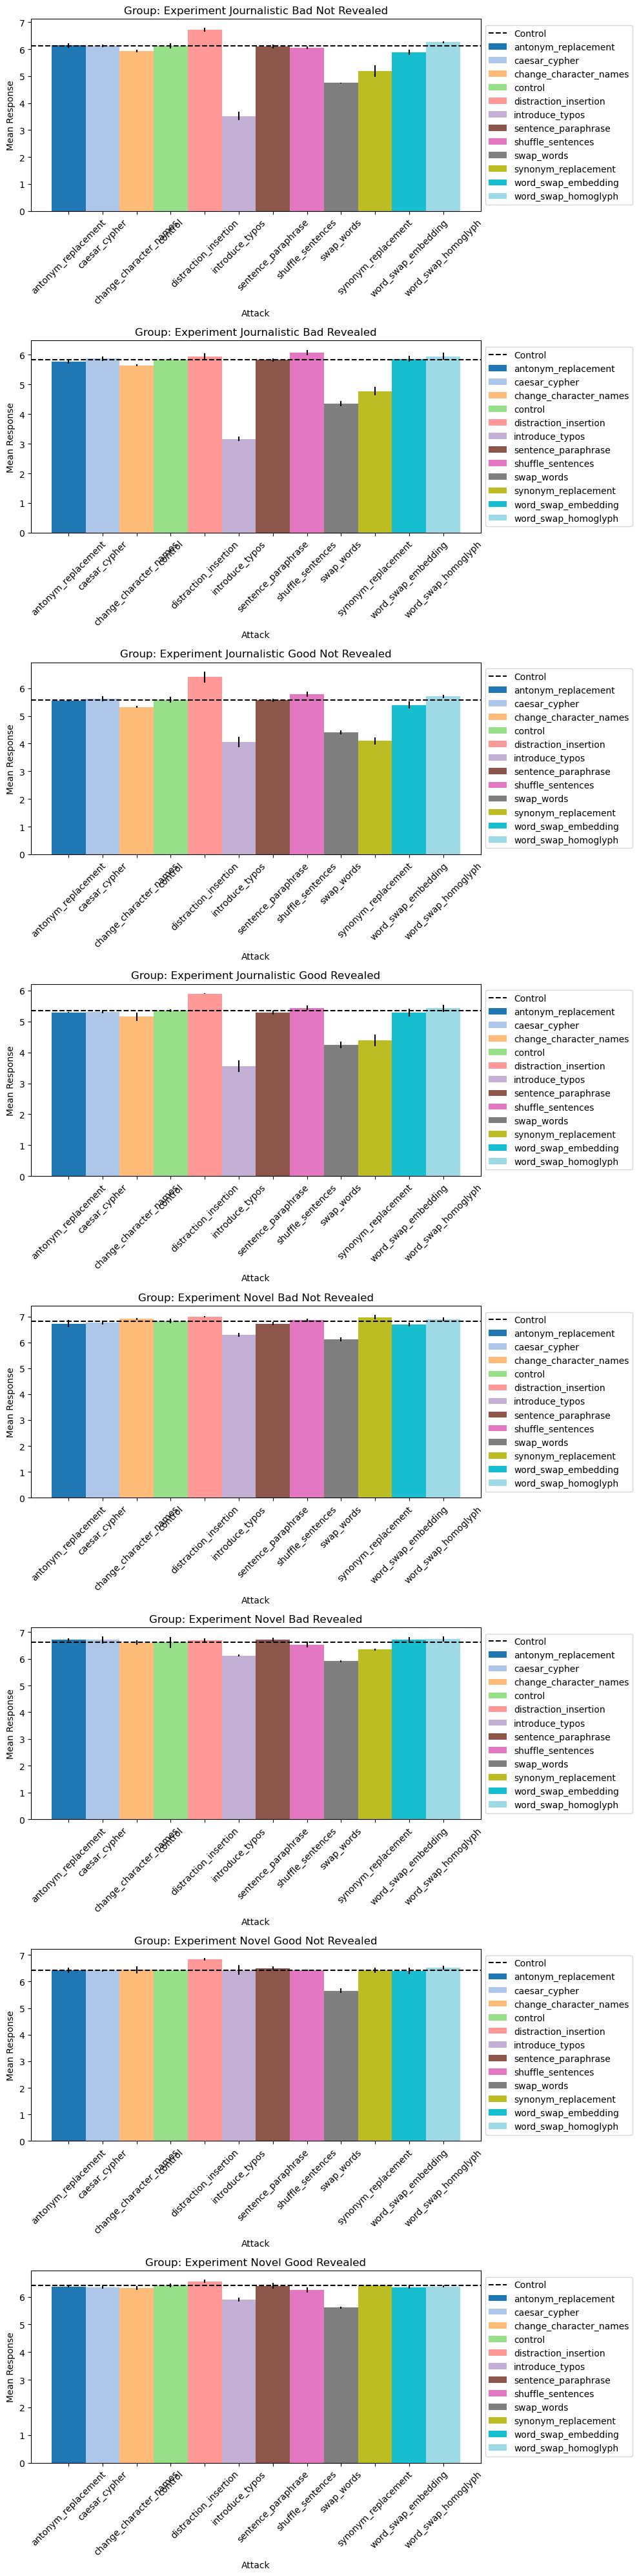

In [15]:
def plot_experiment(_df : pd.DataFrame, experiment_name : str):
    
    _df['group'] = _df['experiment_name'] + ' ' + _df['version']
    
    groups = _df['group'].unique()
    attacks = _df['attack'].unique()
    fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(10, 5 * len(groups)))
    if len(groups) == 1:
        axes = [axes]
    for ax, group in zip(axes, groups):
        group_df = _df[_df['group'] == group]
        index = np.arange(len(attacks))
        bar_width = 0.35
        colors = plt.cm.tab20(np.linspace(0, 1, len(attacks)))
        for i, attack in enumerate(attacks):
            bar = ax.bar(index[i] * bar_width, group_df[group_df['attack'] == attack][KEY_TO_PLOT]['mean'], bar_width, 
                 yerr=group_df[group_df['attack'] == attack][KEY_TO_PLOT]['std'], label=attack, color=colors[i])
        control_mean = group_df[group_df['attack'] == 'control'][KEY_TO_PLOT]['mean'].values[0]
        ax.axhline(y=control_mean, color='black', linestyle='--', label='Control')
        ax.set_title(f'Group: {group}')
        ax.set_xlabel('Attack')
        ax.set_ylabel('Mean Response')
        ax.set_xticks(index * bar_width)
        ax.set_xticklabels(attacks)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

plot_experiment(out, 'gerrig')

/tmp/ipykernel_1663325/1492831788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_attacks['diff'] = other_attacks[KEY_TO_PLOT]['mean'] - control_mean
/tmp/ipykernel_1663325/1492831788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_attacks['diff_std'] = np.sqrt(other_attacks[KEY_TO_PLOT]['std']**2 + control_std**2)


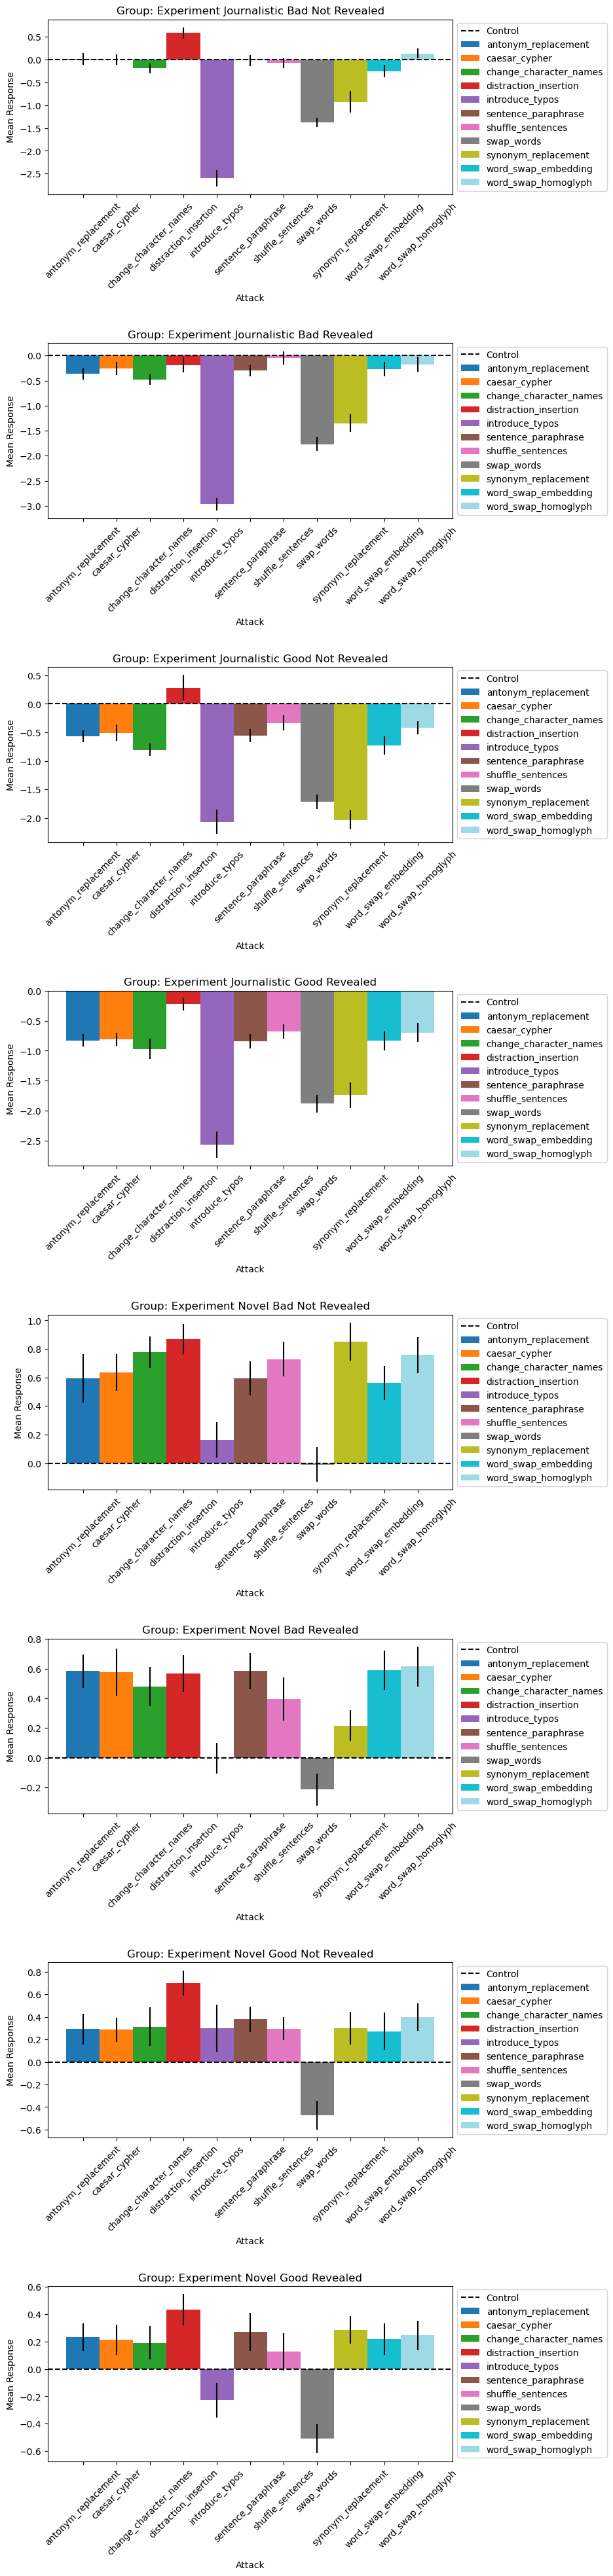

In [16]:
def get_difference_from_control(_df : pd.DataFrame):
    control_mean, control_std = _df[_df['attack'] == 'control'][KEY_TO_PLOT].values[0]
    other_attacks = _df[_df['attack'] != 'control']
    other_attacks['diff'] = other_attacks[KEY_TO_PLOT]['mean'] - control_mean
    other_attacks['diff_std'] = np.sqrt(other_attacks[KEY_TO_PLOT]['std']**2 + control_std**2)
    return other_attacks
    
def plot_difference_from_control(_df : pd.DataFrame):
    
    groups = _df['group'].unique()
    attacks = _df['attack'].unique()
    fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(10, 5 * len(groups)))
    if len(groups) == 1:
        axes = [axes]
    for ax, group in zip(axes, groups):
        group_df = _df[_df['group'] == group]
        index = np.arange(len(attacks))
        bar_width = 0.35
        colors = plt.cm.tab20(np.linspace(0, 1, len(attacks)))
        for i, attack in enumerate(attacks):
            bar = ax.bar(index[i] * bar_width, group_df[group_df['attack'] == attack]['diff'], bar_width, 
                 yerr=group_df[group_df['attack'] == attack]['diff_std'], label=attack, color=colors[i])
        ax.axhline(y=0, color='black', linestyle='--', label='Control')
        ax.set_title(f'Group: {group}')
        ax.set_xlabel('Attack')
        ax.set_ylabel('Mean Response')
        ax.set_xticks(index * bar_width)
        ax.set_xticklabels(attacks)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

diff = get_difference_from_control(out)
plot_difference_from_control(diff)
plt.tight_layout(pad=3.0)
plt.show()
